# Ideas

- train with sun events and experiment with metric
- add months
- change FE model to resnet50/resnet18
- different loss (Focal Loss, KL divergence)

In [17]:
import pandas as pd
import torch
from pathlib import Path
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from src.utils.metrics import event_detection_ap

from src.utils.post_process import post_process_for_seg
import jupyter_black
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna


jupyter_black.load()
plt.style.use("ggplot")

EXP_NAME = "sun"
RUN_NAME = "run2"
RESULT_DIR = Path("../output/train") / EXP_NAME / RUN_NAME


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix())
    # load the config
    cfg = compose(config_name="config")

    return cfg

In [18]:
cfg = load_config(RESULT_DIR)
preds = np.load(RESULT_DIR / "preds.npy")
labels = np.load(RESULT_DIR / "labels.npy")
keys = np.load(RESULT_DIR / "keys.npy")

gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(cfg.split.valid_series_ids)].dropna().reset_index(drop=True)

/tmp/ipykernel_27144/1883481260.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())


In [19]:
# pred_df: pl.DataFrame = post_process_for_seg(
#     keys, preds[:, :, [1, 2]], score_th=0.001, distance=80
# )
# score = event_detection_ap(gt_df, pred_df.to_pandas())
# score

0.7461083428653215

In [20]:
def objective(trial: optuna.Trial):
    # score_th = 0.005
    score_th = trial.suggest_float("score_th", 0.001, 0.2)
    distance = trial.suggest_int("distance", 1, 200)

    pred_df: pl.DataFrame = post_process_for_seg(
        keys, preds[:, :, [1, 2]], score_th=score_th, distance=distance
    )
    score = event_detection_ap(gt_df, pred_df.to_pandas())

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

[I 2023-11-07 17:20:52,930] A new study created in memory with name: no-name-5255c69e-e7ec-4121-a0d0-dfb9b122388e
[I 2023-11-07 17:20:55,247] Trial 0 finished with value: 0.7439541091219273 and parameters: {'score_th': 0.01020153779695843, 'distance': 70}. Best is trial 0 with value: 0.7439541091219273.
[I 2023-11-07 17:20:57,366] Trial 1 finished with value: 0.7022959531402239 and parameters: {'score_th': 0.15190558856056222, 'distance': 145}. Best is trial 0 with value: 0.7439541091219273.
[I 2023-11-07 17:20:59,507] Trial 2 finished with value: 0.7142812514371959 and parameters: {'score_th': 0.12204359127043028, 'distance': 114}. Best is trial 0 with value: 0.7439541091219273.
[I 2023-11-07 17:21:01,458] Trial 3 finished with value: 0.6993963743526013 and parameters: {'score_th': 0.17071788534978993, 'distance': 129}. Best is trial 0 with value: 0.7439541091219273.
[I 2023-11-07 17:21:03,592] Trial 4 finished with value: 0.7253094911626512 and parameters: {'score_th': 0.080109554767

KeyboardInterrupt: 

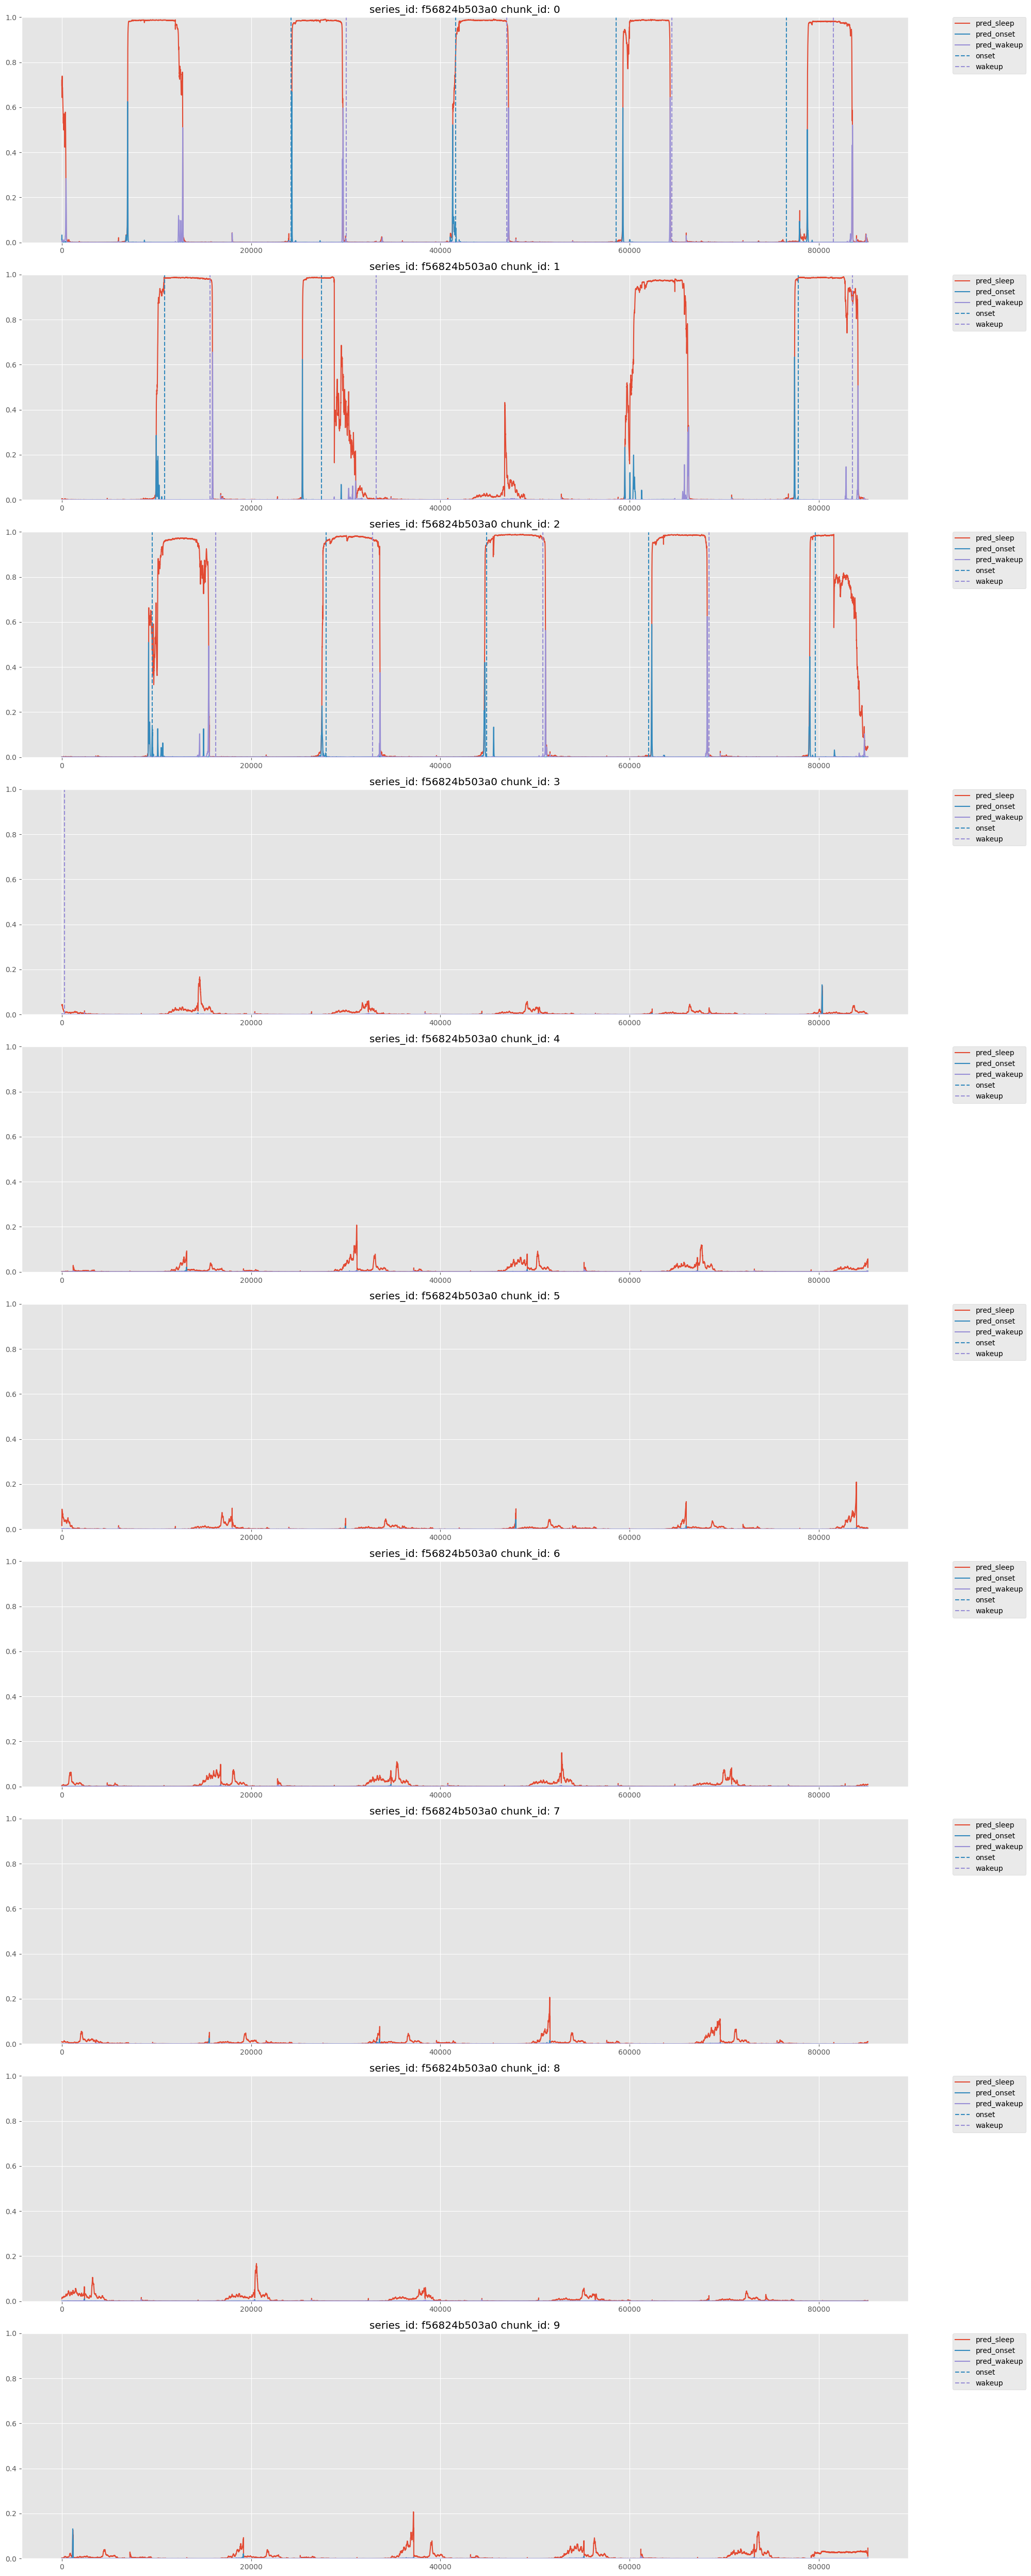

In [33]:
def plot_random_sample(gt_df, keys, preds, labels, num_samples=1, num_chunks=10):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    # get random series
    random_series_ids = np.random.choice(unique_series_ids, num_samples)

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)
        this_series_len = [0] + [len(x) for x in this_series_labels]
        this_series_len = np.cumsum(this_series_len)

        gt_df = gt_df[gt_df["series_id"] == random_series_id]

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 5 * num_chunks))

        if num_chunks == 1:
            axs = [axs]

        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            gt_tmp = gt_df[
                (gt_df["step"] >= this_series_len[j]) & (gt_df["step"] <= this_series_len[j + 1])
            ]
            onset_idx = gt_tmp.loc[gt_tmp["event"] == "onset", "step"].to_list()
            onset_idx = onset_idx - this_series_len[j]
            wakeup_idx = gt_tmp.loc[gt_tmp["event"] == "wakeup", "step"].to_list()
            wakeup_idx = wakeup_idx - this_series_len[j]

            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
            axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            axs[j].vlines(onset_idx, 0, 1, label="onset", linestyles="dashed", color="C1")
            axs[j].vlines(wakeup_idx, 0, 1, label="wakeup", linestyles="dashed", color="C2")
            axs[j].set_ylim(0, 1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()


plot_random_sample(gt_df, keys, preds, labels, num_chunks=10)